In [7]:
import pandas as pd

# Feature Enigneering

def preProcessing(dataset, isTrain):
    
    # For name, we simply drop it.
    # Though I still think name can be useful by using a semantics mapping or sth
    dataset = dataset.drop(columns = ['name', 'teleplay_id'])

    # For type: we use a dummy coding method. Generate three more columns, short, medium, and long
    short_col = []
    medium_col = []
    long_col = []
    special_col = []
    music_col = []
    ona_col = []
    type_sorts = {}
    for index in dataset.index:
        if(dataset['type'][index] not in type_sorts):
            type_sorts[dataset['type'][index]] = 1
        else:
            type_sorts[dataset['type'][index]] += 1
        if(dataset['type'][index] == ""): # missing value
            short_col.append(0)
            medium_col.append(0)
            long_col.append(0)
            special_col.append(0)
            music_col.append(0)
            ona_col.append(0)
        elif(dataset['type'][index] == "short"):
            short_col.append(1)
            medium_col.append(0)
            long_col.append(0)
            special_col.append(0)
            music_col.append(0)
            ona_col.append(0)
        elif(dataset['type'][index] == "medium"):
            short_col.append(0)
            medium_col.append(1)
            long_col.append(0)
            special_col.append(0)
            music_col.append(0)
            ona_col.append(0)
        elif(dataset['type'][index] == "long"):
            short_col.append(0)
            medium_col.append(0)
            long_col.append(1)
            special_col.append(0)
            music_col.append(0)
            ona_col.append(0)
        elif(dataset['type'][index] == "Special"):
            short_col.append(0)
            medium_col.append(0)
            long_col.append(0)
            special_col.append(1)
            music_col.append(0)
            ona_col.append(0)
        elif(dataset['type'][index] == "Music"):
            short_col.append(0)
            medium_col.append(0)
            long_col.append(0)
            special_col.append(0)
            music_col.append(1)
            ona_col.append(0)
        elif(dataset['type'][index] == "ONA"):
            short_col.append(0)
            medium_col.append(0)
            long_col.append(0)
            special_col.append(0)
            music_col.append(0)
            ona_col.append(1)

    dataset['tp_short'] = pd.DataFrame(short_col)
    dataset['tp_medium'] = pd.DataFrame(medium_col)
    dataset['tp_long'] = pd.DataFrame(long_col)
    dataset['tp_special'] = pd.DataFrame(special_col)
    dataset['tp_music'] = pd.DataFrame(special_col)
    dataset['tp_ona'] = pd.DataFrame(special_col)
    dataset = dataset.drop(columns = ['type'])

    # For episodes, we tentatively do not change into a bin-interval data.
    # However, in the future version we can do this for realistic consideration, since we often have long episodes, short episodes etc.

    # if the dataset is for training, we drop all the entries without rating
    rows_drop = []
    for index in dataset.index:
        if(dataset['episodes'][index] == "Unknown"):
            dataset.loc[index, 'episodes'] = 0 # treat unknow as 0
        if(dataset['rating'][index] == ""):
            if(isTrain):
                rows_drop.append(index)
            else:
                dataset.loc[index, 'rating'] = -1
    dataset = dataset.drop(rows_drop)
    dataset['episodes'] = pd.to_numeric(dataset['episodes'])
    dataset['rating'] = pd.to_numeric(dataset['rating'])

    # For members, we check the minimum and maximum of it
    print(dataset['members'].min(), dataset['members'].max())


    # For genres, we first get the summation of each genere, drop those genre rarely appeared.
    # Then we also use dummy variables to transform it into multiple variables.
    genre_set = set()
    for index in dataset.index:
        if(dataset['genre'][index] == ""):
            # print(dataset.loc[[index]])
            continue
        genres = dataset['genre'][index].split(",")
        for ge in genres:
            ge = ge.strip()
            genre_set.add(ge)

    for genre in genre_set:
        dataset[genre] = 0

    for index in dataset.index:
        if(dataset['genre'][index] == ""):
            # print(dataset.loc[[index]])
            continue
        genres = dataset['genre'][index].split(",")
        for ge in genres:
            ge = ge.strip()
            dataset.loc[index, ge] = 1

    dataset = dataset.drop(columns = ['genre'])
    # print(genre_dict)
    return dataset
dataset = pd.read_csv('Teleplay.csv').fillna('')

test_data = pd.read_csv('New_Teleplay.csv').fillna("")

dataset = preProcessing(dataset, True)
test_data = preProcessing(test_data, False)
# dataset.shape


13 1013917
12 793665


(10011, 52)

In [9]:

# Train set, test set spliting and normailzation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

y = dataset['rating'].to_numpy()
X = dataset.drop(columns='rating').to_numpy()
test_data_X = test_data.drop(columns='rating').to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# fit scaler on training data
norm = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing data
X_test_norm = norm.transform(X_test)
test_data_X_norm = norm.transform(test_data_X)


In [10]:
class LinearRegressionUsingGD:
    """Linear Regression Using Gradient Descent.
    Parameters
    ----------
    eta : float
        Learning rate
    n_iterations : int
        No of passes over the training set
    Attributes
    ----------
    w_ : weights/ after fitting the model
    bias_ : bias / after fitting the model
    cost_ : total error of the model after each iteration
    """

    def __init__(self, eta=0.05, n_iterations=50000):
        self.eta = eta
        self.n_iterations = n_iterations

    def fit(self, x, y):
        """Fit the training data
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Training samples
        y : array-like, shape = [n_samples, n_target_values]
            Target values
        Returns
        -------
        self : object
        """
        self.cost_ = []
        self.w_ = np.zeros((x.shape[1], 1))
        self.bias_ = np.zeros((1, 1))
        m = x.shape[0]

        for _ in range(self.n_iterations):
            # print(x.shape, self.w_.shape)
            y_pred = np.dot(x, self.w_) + self.bias_
            residuals = np.subtract(y_pred,y.reshape(len(y),1))
            gradient_vector_weight = np.dot(x.T, residuals)
            gradient_vector_bias = np.sum(residuals)
            # print(gradient_vector_weight.shape) 
            self.w_ -= (self.eta / m) * gradient_vector_weight
            self.bias_ -= (self.eta / m) * gradient_vector_bias
            cost = np.sum((residuals ** 2)) / (2 * m)
            self.cost_.append(cost)
        return self

    def predict(self, x):
        """ Predicts the value after the model has been trained.
        Parameters
        ----------
        x : array-like, shape = [n_samples, n_features]
            Test samples
        Returns
        -------
        Predicted value
        """
        return np.dot(x, self.w_) + self.bias_

Root mean squared error of train set:  0.6710420368852371
R2 score train set:  0.36899123709604387
Root mean squared error of test set:  0.6634889743373525
R2 score test set:  0.3472730337158747


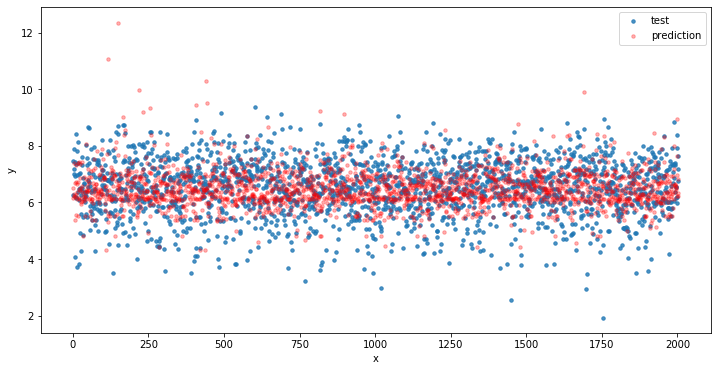

In [18]:
# Using linear regression to train model and predict
import numpy as np 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


reg = LinearRegressionUsingGD().fit(X_train_norm, y_train)

y_pred = reg.predict(X_train_norm)

rmse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print('Root mean squared error of train set: ', rmse)
print('R2 score train set: ', r2)

y_pred = reg.predict(X_test_norm)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Root mean squared error of test set: ', rmse)
print('R2 score test set: ', r2)

x = np.arange(1, len(y_pred)+1)

# plot
plt.figure(figsize=(12,6))
plt.scatter(x,y_test,alpha=0.8,s=12)
plt.xlabel('x')
plt.ylabel('y')
plt.scatter(x, y_pred, color='r', alpha=0.3,s=12)
plt.legend(["test", "prediction"], loc="upper right")
plt.savefig("linear.png")

test_y_pred = reg.predict(test_data_X_norm)



In [17]:
#import new teleplay.csv
test_y_pred = test_y_pred.reshape(len(test_y_pred),)

test_data = pd.read_csv('New_Teleplay.csv').fillna("")

test_data['rating'] = test_y_pred

test_data.to_csv("17082834d_task1.csv")

array([6.43687163, 5.48229248, 5.5043442 , ..., 5.79352341, 6.00493617,
       7.12055883])